In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
X_train = np.load('X_train.npy')
X_valid = np.load('X_valid.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_valid = np.load('y_valid.npy')
y_test = np.load('y_test.npy')

X_train = X_train.reshape( (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1) )
X_valid = X_valid.reshape( (X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1) )
X_test = X_test.reshape( (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1) )
y_train = y_train.reshape( (-1, 1) )
y_valid = y_valid.reshape( (-1, 1) )
y_test = y_test.reshape( (-1, 1) )
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(161825, 120, 25, 1) (161825, 1)
(5000, 120, 25, 1) (5000, 1)
(10000, 120, 25, 1) (10000, 1)


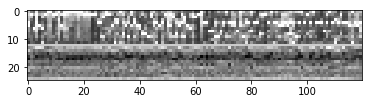

In [3]:
plt.imshow(X_train[0, :, :, 0].T, cmap='gray')

In [4]:
med = np.median(y_train)

def accuracy(pred, labels):
    return ( (pred > med) == (labels > med) ).mean()*100

In [5]:
batch_size = 128
time = 120
num_features = 25
epsilon = 1e-8

#shape[0]==0 - max_pool
#shape[0]==1 - conv2d
convs = [
    [1, 1, 25, 1, 64]
    #[1, 1, 1, 64, 128]
]

overall_size = 0

size = time, num_features
for s in convs:
    print(size)
    if s[0]==1:
        size = size[0] - s[1] + 1, size[1] - s[2] + 1
    else:
        size = size[0]//s[2], size[1]//s[3]

#res consists of depth and stride
res = [
    [64, 1, 1],
    [64, 1, 1],
    [64, 1, 1],
    [64, 1, 1],
    [64, 1, 1],
    [128, 2, 1],
    [128, 1, 1],
    [128, 1, 1],
    [128, 1, 1],
    [128, 1, 1],
    [256, 2, 1],
    [256, 1, 1],
    [256, 1, 1],
    [256, 1, 1],
    [256, 1, 1],
    [512, 2, 1],
    [512, 1, 1],
    [512, 1, 1],
    [512, 1, 1],
    [512, 1, 1],
    [1024, 2, 1]
]

for r in res:
    size = size[0]//r[1]+size[0]%r[1], size[1]//r[2]+size[1]%r[2]
overall_size = size[0]*size[1]*res[-1][0]

dense = [
    [overall_size, 1]
]
dense_dropout = [1.0]

graph = tf.Graph()

with graph.as_default():

  # Input data.
  X_tr = tf.placeholder(
    tf.float32, shape=(batch_size, time, num_features, 1))
  y_tr = tf.placeholder(tf.float32, shape=(batch_size, 1))

  X_val = tf.constant(np.float32(X_valid))
    
  X_te = tf.constant(np.float32(X_test[:5000]))

  # Variables.
  w_conv = []
  b_conv = []
  for s in convs:
    if s[0]==1:
        w_conv.append(tf.Variable(tf.truncated_normal(s[1:], stddev=0.1)))
        b_conv.append(tf.Variable(tf.zeros([s[-1]])))

  w_res = []
  b_res = []
  for r in res:
    if r[1]==1:
        w_res.append( (tf.Variable(tf.truncated_normal([3, 3, r[0]//r[1], r[0]], stddev=0.03)),
                       tf.Variable(tf.truncated_normal([3, 3, r[0], r[0]], stddev=0.03))) )
        b_res.append( (tf.Variable(tf.zeros(r[0])),
                       tf.Variable(tf.zeros(r[0]))) )
    else:
        w_res.append( (tf.Variable(tf.truncated_normal([3, 3, r[0]//r[1], r[0]], stddev=0.03)),
                       tf.Variable(tf.truncated_normal([3, 3, r[0], r[0]], stddev=0.03)),
                       tf.Variable(tf.truncated_normal([1, 1, r[0]//r[1], r[0]], stddev=0.03))) )
        b_res.append( (tf.Variable(tf.zeros(r[0])),
                       tf.Variable(tf.zeros(r[0])),
                       tf.Variable(tf.zeros(r[0]))) )

  w_dense = []
  b_dense = []
  for s in dense:
    w_dense.append(tf.Variable(tf.truncated_normal(s, stddev=0.1)))
    b_dense.append(tf.Variable(tf.zeros(s[1])))

  def residual(y, ind):
    shortcut = y
    y = tf.nn.conv2d(y, w_res[ind][0], [1, res[ind][1], res[ind][2], 1], padding='SAME')
    y = y + b_res[ind][0]
    m, v = tf.nn.moments(y, -1, keep_dims=True)
    y = (y - m) / tf.maximum(v, epsilon)
    y = tf.nn.leaky_relu(y)
    
    y = tf.nn.conv2d(y, w_res[ind][1], [1, 1, 1, 1], padding='SAME')
    y = y + b_res[ind][1]
    m, v = tf.nn.moments(y, -1, keep_dims=True)
    y = (y - m) / tf.maximum(v, epsilon)
    
    if res[ind][1]>1:
        shortcut = tf.nn.conv2d(shortcut, w_res[ind][2], [1, res[ind][1], res[ind][2], 1], padding='SAME')
        shortcut = shortcut + b_res[ind][2]
        m, v = tf.nn.moments(shortcut, -1, keep_dims=True)
        shortcut = (shortcut - m) / tf.maximum(v, epsilon)
    
    y = y + shortcut
    y = tf.nn.leaky_relu(y)
    return y

  # Model.
  def model(X, train=False):
    hidden = X
    j=0
    for i in range(len(convs)):
        if convs[i][0]==1:
            hidden = tf.nn.conv2d(hidden, w_conv[j], [1, 1, 1, 1], padding='VALID')
            hidden = tf.nn.relu(hidden + b_conv[j])
            j += 1
        else:
            hidden = tf.nn.max_pool(hidden, convs[i][1:], convs[i][1:], padding='VALID')
        if train: print('conv2d', hidden.get_shape())
    
    for i in range(len(res)):
        hidden = residual(hidden, i)
        if train: print('residual', hidden.get_shape())
    
    shape = hidden.get_shape().as_list()
    hidden = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    #print( hidden.get_shape() , w_dense[0].get_shape())
    for i in range(len(w_dense)):
        hidden = tf.nn.xw_plus_b(hidden, w_dense[i], b_dense[i])
        if i < len(w_dense)-1:
            hidden = tf.nn.relu(hidden)
            hidden = tf.nn.dropout(hidden, dense_dropout[i])
    
    return hidden
  
  # Training computation.
  logits = model(X_tr, train=True)
  loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=y_tr, logits=logits))
    
  # Optimizer.
  #optimizer = tf.train.AdagradOptimizer(1e-3).minimize(loss)
  optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.sigmoid(logits)
  valid_prediction = tf.nn.sigmoid(model(X_val))
  test_prediction = tf.nn.sigmoid(model(X_te))

(120, 25)
conv2d (128, 120, 1, 64)
residual (128, 120, 1, 64)
residual (128, 120, 1, 64)
residual (128, 120, 1, 64)
residual (128, 120, 1, 64)
residual (128, 120, 1, 64)
residual (128, 60, 1, 128)
residual (128, 60, 1, 128)
residual (128, 60, 1, 128)
residual (128, 60, 1, 128)
residual (128, 60, 1, 128)
residual (128, 30, 1, 256)
residual (128, 30, 1, 256)
residual (128, 30, 1, 256)
residual (128, 30, 1, 256)
residual (128, 30, 1, 256)
residual (128, 15, 1, 512)
residual (128, 15, 1, 512)
residual (128, 15, 1, 512)
residual (128, 15, 1, 512)
residual (128, 15, 1, 512)
residual (128, 8, 1, 1024)


Initialized
Avg loss at step 0: 498.434509
Minibatch accuracy: 51.6%
Validation accuracy: 50.8%
Avg loss at step 100: 37.577997
Minibatch accuracy: 46.9%
Validation accuracy: 49.6%
Avg loss at step 200: 0.658820
Minibatch accuracy: 45.3%
Validation accuracy: 50.8%
Avg loss at step 300: 0.655435
Minibatch accuracy: 47.7%
Validation accuracy: 51.2%
Avg loss at step 400: 0.659418
Minibatch accuracy: 51.6%
Validation accuracy: 53.1%
Avg loss at step 500: 0.661886
Minibatch accuracy: 57.0%
Validation accuracy: 50.8%
Avg loss at step 600: 0.660224
Minibatch accuracy: 53.1%
Validation accuracy: 54.3%
Avg loss at step 700: 0.656980
Minibatch accuracy: 57.0%
Validation accuracy: 53.0%
Avg loss at step 800: 0.656667
Minibatch accuracy: 55.5%
Validation accuracy: 51.6%
Avg loss at step 900: 0.659399
Minibatch accuracy: 50.8%
Validation accuracy: 54.5%
Avg loss at step 1000: 0.664767
Minibatch accuracy: 57.0%
Validation accuracy: 51.1%
Avg loss at step 1100: 0.660591
Minibatch accuracy: 47.7%
Vali

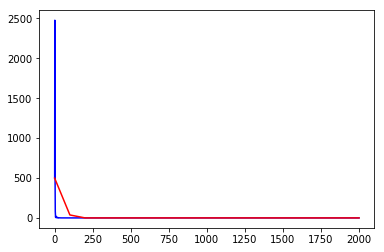

In [6]:
num_steps = 2001

with tf.Session(graph=graph) as session:
  losses=[]
  avg=[]
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (y_train.shape[0] - batch_size)
    batch_data = X_train[offset:(offset + batch_size), :, :, :]
    batch_labels = y_train[offset:(offset + batch_size), :]
    feed_dict = {X_tr : batch_data, y_tr : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    losses.append(l)
    if (step % 100 == 0):
      avg.append(sum(losses[-100:])/len(losses[-100:]))
      print('Avg loss at step %d: %f' % (step, avg[-1]))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), y_valid))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), y_test[:5000]))
  plt.plot(range(num_steps), losses, 'b', np.array(range(len(avg)))*100, avg, 'r')
  plt.show()